# Bottleneck Power Calculation

The goal of this notebook is to respond to comment from **Reviewer 1** on the manuscript. The reviewer’s main point is that we cannot claim that the bottleneck was narrow given our cohort’s low initial within-host viral diversity. 

However, we without rich allelic diversity in a donor population, you can make a broad assesment of the bottleneck size if you observe high-frequency alleles that aren't shared between individuals.

In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import binom, betabinom, beta, poisson, expon, norm
from plotnine import *

## Probability of Transmission

What's the probability of transmitting a viral variant given it's initial frequency in a donor virus population? We observe several alleles at high frequency that aren't shared between crew memebers. It's very likely that these *would* be shared if the bottleneck wasn't narrow. Here, I'll attempt to prove that with the most commonly used model for estimating viral transmission bottlenecks from deep-sequencing data from [this paper](https://doi.org/10.1128/JVI.00171-17).

From the beta-binomial model of viral transmission bottlenecks, what's the probability that a mutations at allele frequency $vD_i$ will be transmitted to a recipient at a detectable frequency ( $\ge$ 2%) given a bottleneck of $N_b$?

In [10]:
T = 0.02 # Our Variant Calling Threshold
vD_is = np.linspace(0.02, .5, 10) # Variant Frequency in the Donor
N_bs = np.geomspace(1, 10_000, 100, dtype = int) # Log Spaced values for bottleneck 

df_list = list()
for vD_i in vD_is:
    final_prob_list = list()
    for N_b in N_bs:
        final_prob = 0
        for k in range(1, (N_b)):
            
            # What's the prob. of observing the variant at more than 2% frequency?
            final_prob += (1 - beta.cdf(T, k, (N_b - k))) * binom.pmf(k, N_b, vD_i)
            
        final_prob_list.append(final_prob)
    df = pd.DataFrame(zip(N_bs, final_prob_list), columns = ['Bottleneck', 'Probability of Transmission'])
    df['Frequency'] = vD_i
    df_list.append(df)
    
bottlenecks = pd.concat(df_list)

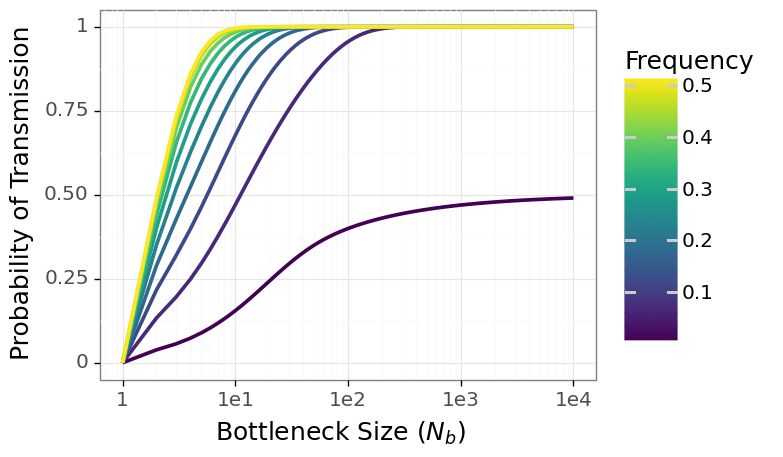

<ggplot: (8753922102013)>

In [11]:
(
ggplot(data = bottlenecks, mapping = aes(x = "Bottleneck", y = "Probability of Transmission"))
    + geom_line(aes(group ='Frequency', colour='Frequency'), size = 1.5)
    + xlab("Bottleneck Size ($N_b$)")
    + scale_x_log10()
    + theme_bw(18)
)

Even a variant at 20-30% allele frequency in a donor population has a tremendously high probability of being observed in a recipient population after a single transmission event, even if the bottleneck is quite narrow ($N_b \approx$ 10). 

### Using Real Data

Now, I'll do this with viral alleles identified in the high-quality deep-sequencing data from *our cohort*. Given the frequency of these variants, how likely are these variants to be shared if the crew were directly connected by transmission? 

In [12]:
# Our Variant Calling Threshold
T = 0.02 
# Our real data. 
real_vD_is = [(.58, "C17125T"), (.37, "G21608T"), (.23, "C28531T"), (.21, "A26358G"), (.1, "C24370T"), (.08, "C25214A"), (.05, "G23868T")] # Variant Frequency in our data between 0 and .98
# Logarithimically spaced bottleneck values. 
N_bs = np.geomspace(1, 10_000, 100, dtype = int) # Log Spaced values for bottleneck 

df_list = list()
for vD_i, allele in real_vD_is:
    final_prob_list = list()
    for N_b in N_bs:
        final_prob = 0
        for k in range(1, (N_b)):
            final_prob += (1 - beta.cdf(T, k, (N_b - k))) * binom.pmf(k, N_b, vD_i)
        final_prob_list.append(final_prob)
    df = pd.DataFrame(zip(N_bs, final_prob_list), columns = ['Bottleneck', 'Probability of Transmission'])
    df['Frequency'] = vD_i
    df['Allele'] = allele
    df_list.append(df)
    
real_bottlenecks = pd.concat(df_list)

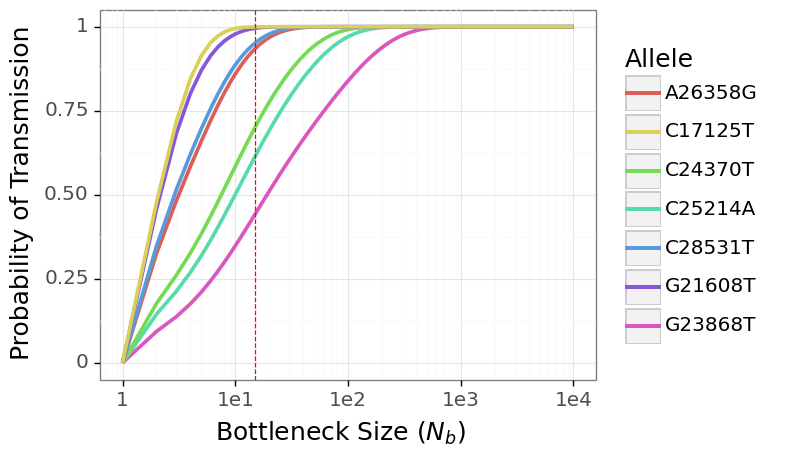

<ggplot: (8753923947573)>

In [13]:
transmission_likelihood_plot = (
ggplot(data = real_bottlenecks, mapping = aes(x = "Bottleneck", y = "Probability of Transmission"))
    + geom_line(aes(group ='Frequency', colour='Allele'), size = 1.5)
    + geom_vline(xintercept = 15, colour = "red", linetype = "dashed")
    + xlab("Bottleneck Size ($N_b$)")
    + scale_x_log10()
    + theme_bw(18)
)

transmission_likelihood_plot

In [14]:
transmission_likelihood_plot.save(filename = 'transmission-likelihood.png', height=5, width=7, units = 'in', dpi=300)

/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 5 in image.
/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: transmission-likelihood.png


These are the seven highest frequency alleles in the cohort that are not fixed. The red line is an approximation of a narrow bottleneck calculated in other studies of SARS-CoV-2 transmission ($N_b$ = 15). For several of these variants, even if the bottleneck were narrow, we expect them to be shared during transmission with a probability approaching 1. 